In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.21.2
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Fri Jul 15 08:14:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   28C    P8    20W / 250W |  10570MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

In [4]:
import torch
print(torch.__version__)
print(torch.cuda)

1.8.2+cu111
<module 'torch.cuda' from '/data/home/sokoloff/.local/lib/python3.7/site-packages/torch/cuda/__init__.py'>


> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.21.2


### Set up local parameters

In [6]:
n_epochs = 100

# Name is the output file name


##  201019  mds
folder = '15July_testing_HalfDozen_first_learning_iter0_100epochs_1em5'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 1e-5

Make the output directory if it does not exist:

In [7]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [8]:
## collectdata_kde_Ellipsoids_29Aug2021 adds zBin and zOffset to X[]
## from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
##from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
## revert to traditional collect_t2kde_data
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
## use July 2022 version of collect_t2kde_data for testing stgructure
## (and later for modifying structure of X[] and Y[])
from model.collectdata_kde_Ellipsoids_jul2022 import collect_t2kde_data


## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
from model.interval_kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_July2022_kde import TrackIntervalsToKDE_HalfDozen as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [9]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [10]:
##device = "cuda"
device = select_gpu(2)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 3090


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [12]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
loss = Loss(epsilon=3e-6)

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
ct, child =  5    Linear(in_features=20, out_features=100, bias=True)


Let's move the model's weight matricies to the GPU:

In [13]:
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]


model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/15July_testing_HalfDozen_first_learning_iter0_100epochs_1em5
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias


In [16]:
"""
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')

##  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
pretrained_dict = torch.load('ML/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6_final.pyt')
print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)
"""

'\n##print("updated model_dict = ",model_dict)\n\n## print(" \n","  for pretrained_dict")\n## index = 0\n##for k,v in pretrained_dict.items():\n##    print("index, k =  ",index,"  ",k)\n##    index = index+1\n## mds  \n\n##pretrained_dict = torch.load(\'ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt\')\n##print("model_dict instantiated")\n# 1. filter out unnecessary keys\n##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}\n##print("pretrained_dict iterated")\n# 2. overwrite entries in the existing state dict\n##model_dict.update(pretrained_dict) \n##\n#   when starting from a model with a fully connected last layer rather than a convolutional layer\n# 3. load the new state dict\n#   need to use strict=False as the two models state model attributes do not agree exactly\n#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict\n\

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [17]:
## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/100_POCA_kernel_evts_210829.h5',                                  
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                           device=device,
##  slice is used as index in feature set defined in terms of intervals
##  and there are 800K intervals in a file with 20K events
                           slice = slice(None,700000)
                           )
                            

Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (800000, 100)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6

len(X) =  20000
len(X_ints) = 800000
len(Xlist) =  1
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 97.68 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 4.649 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t_intervals.shape =  torch.Size([700000, 9, 300])
x_t_intervals.shape[0] =  700000
x_t_intervals.shape[1] =  9
y_t.shape =  torch.Size([20000, 12000])
y_t_intervals.shape =  torch.Size([700000, 300])
y_t_intervals.shape[0] =  700000
y_t_intervals.shape[1] =  300


In [18]:
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
##                            slice = slice(700000,None)
                           )

Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (800000, 100)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6

len(X) =  20000
len(X_ints) = 800000
len(Xlist) =  1
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 95.52 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 4.839 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t_intervals.shape =  torch.Size([800000, 9, 300])
x_t_intervals.shape[0] =  800000
x_t_intervals.shape[1] =  9
y_t.shape =  torch.Size([20000, 12000])
y_t_intervals.shape =  torch.Size([800000, 300])
y_t_intervals.shape[0] =  800000
y_t_intervals.shape[1] =  300


with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


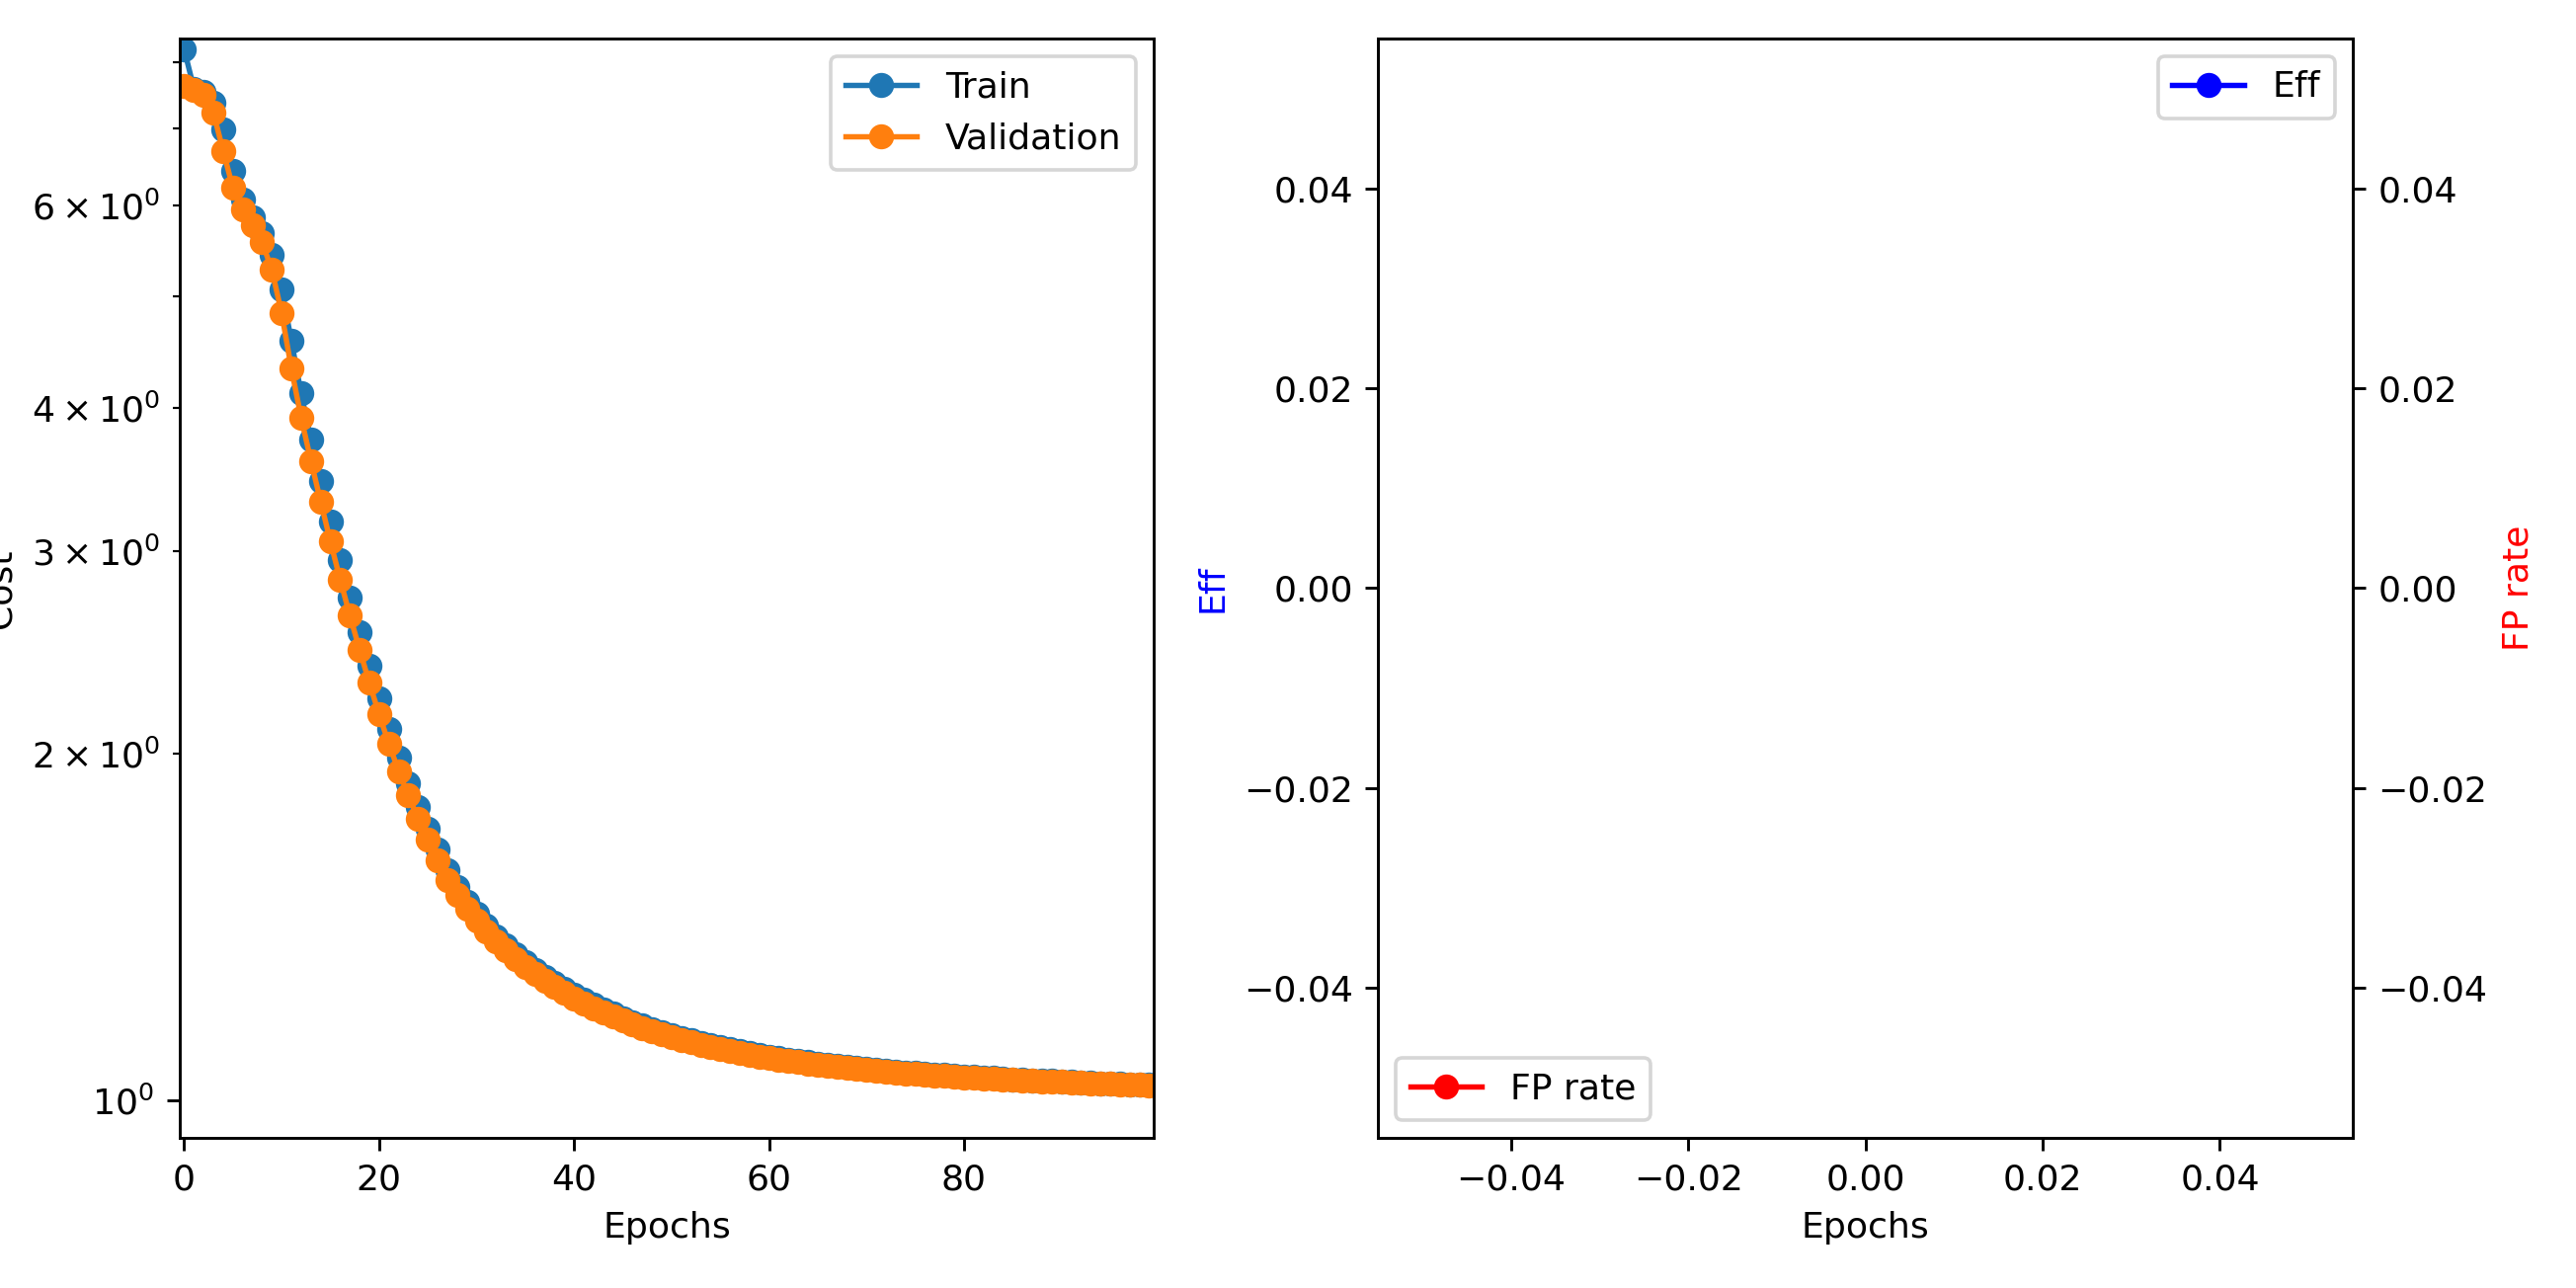

In [19]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [20]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 10938, val = 12500


Number of batches: train = 10938, val = 12500


Epoch 0: train=8.20413, val=7.62575, took 130.05 s


Epoch 1: train=7.5851, val=7.56656, took 126.07 s


Epoch 2: train=7.53368, val=7.48665, took 119.99 s


Epoch 3: train=7.37553, val=7.2244, took 117.73 s


Epoch 4: train=6.98362, val=6.69311, took 117.43 s


Epoch 5: train=6.43086, val=6.21612, took 120.37 s


Epoch 6: train=6.07192, val=5.95385, took 116.78 s


Epoch 7: train=5.85889, val=5.76996, took 116.88 s


Epoch 8: train=5.67597, val=5.57315, took 124.33 s


Epoch 9: train=5.43143, val=5.27251, took 128.42 s


Epoch 10: train=5.07358, val=4.83528, took 120.74 s


Epoch 11: train=4.57421, val=4.3264, took 125.6 s


Epoch 12: train=4.11664, val=3.92204, took 127.77 s


Epoch 13: train=3.75676, val=3.59819, took 126.35 s


Epoch 14: train=3.45745, val=3.31671, took 120.61 s


Epoch 15: train=3.18859, val=3.06098, took 123.75 s


Epoch 16: train=2.94838, val=2.8363, took 124.78 s


Epoch 17: train=2.73766, val=2.63884, took 124.2 s


Epoch 18: train=2.55144, val=2.4634, took 123.41 s


Epoch 19: train=2.38496, val=2.30578, took 123.42 s


Epoch 20: train=2.23487, val=2.16454, took 119.14 s


Epoch 21: train=2.10219, val=2.04084, took 121.15 s


Epoch 22: train=1.98639, val=1.9329, took 125.77 s


Epoch 23: train=1.88601, val=1.83979, took 124.37 s


Epoch 24: train=1.79845, val=1.75698, took 117.13 s


Epoch 25: train=1.72151, val=1.68618, took 116.72 s


Epoch 26: train=1.6524, val=1.61588, took 120.95 s


Epoch 27: train=1.58366, val=1.55441, took 129.63 s


Epoch 28: train=1.53123, val=1.5079, took 211.6 s


Epoch 29: train=1.48847, val=1.46802, took 259.16 s


Epoch 30: train=1.45125, val=1.43303, took 270.95 s


Epoch 31: train=1.41833, val=1.40184, took 296.36 s


Epoch 32: train=1.389, val=1.37402, took 141.06 s


Epoch 33: train=1.36271, val=1.34907, took 130.97 s


Epoch 34: train=1.33901, val=1.32644, took 188.25 s


Epoch 35: train=1.31756, val=1.3059, took 270.79 s


Epoch 36: train=1.298, val=1.28714, took 270.34 s


Epoch 37: train=1.2801, val=1.26999, took 269.45 s


Epoch 38: train=1.26365, val=1.25415, took 274.96 s


Epoch 39: train=1.24855, val=1.23945, took 343.42 s


Epoch 40: train=1.23459, val=1.22605, took 414.45 s


Epoch 41: train=1.22169, val=1.21364, took 416.6 s


Epoch 42: train=1.20968, val=1.20208, took 409.66 s


Epoch 43: train=1.19851, val=1.19131, took 405.31 s


Epoch 44: train=1.18809, val=1.18133, took 406.31 s


Epoch 45: train=1.17839, val=1.17203, took 405.07 s


Epoch 46: train=1.16933, val=1.16348, took 400.8 s


Epoch 47: train=1.16091, val=1.15535, took 402.55 s


Epoch 48: train=1.15307, val=1.1479, took 405.41 s


Epoch 49: train=1.14574, val=1.14071, took 402.6 s


Epoch 50: train=1.13895, val=1.13387, took 405.02 s


Epoch 51: train=1.13261, val=1.1278, took 409.08 s


Epoch 52: train=1.12669, val=1.12221, took 411.95 s


Epoch 53: train=1.12115, val=1.11686, took 411.87 s


Epoch 54: train=1.11598, val=1.11183, took 412.75 s


Epoch 55: train=1.11113, val=1.10716, took 416.85 s


Epoch 56: train=1.10656, val=1.10305, took 415.19 s


Epoch 57: train=1.10227, val=1.09859, took 417.61 s


Epoch 58: train=1.09824, val=1.09471, took 415.51 s


Epoch 59: train=1.09445, val=1.09079, took 419.03 s


Epoch 60: train=1.09089, val=1.08758, took 412.7 s


Epoch 61: train=1.08753, val=1.08439, took 408.09 s


Epoch 62: train=1.08435, val=1.0815, took 409.33 s


Epoch 63: train=1.08136, val=1.07842, took 409.51 s


Epoch 64: train=1.07854, val=1.07556, took 406.22 s


Epoch 65: train=1.07586, val=1.07289, took 407.77 s


Epoch 66: train=1.07329, val=1.07045, took 404.44 s


Epoch 67: train=1.07091, val=1.06828, took 403.63 s


Epoch 68: train=1.06866, val=1.06606, took 403.17 s


Epoch 69: train=1.06649, val=1.06392, took 404.97 s


Epoch 70: train=1.06442, val=1.06204, took 413.45 s


Epoch 71: train=1.06248, val=1.06017, took 412.24 s


Epoch 72: train=1.06061, val=1.05819, took 413.76 s


Epoch 73: train=1.05883, val=1.05643, took 416.77 s


Epoch 74: train=1.05714, val=1.05489, took 345.82 s


Epoch 75: train=1.0555, val=1.05361, took 255.33 s


Epoch 76: train=1.05395, val=1.05179, took 250.01 s


Epoch 77: train=1.05247, val=1.05026, took 251.58 s


Epoch 78: train=1.05103, val=1.04902, took 245.88 s


Epoch 79: train=1.04967, val=1.04771, took 235.37 s


Epoch 80: train=1.04838, val=1.04649, took 236.95 s


Epoch 81: train=1.04713, val=1.0452, took 234.87 s


Epoch 82: train=1.04592, val=1.04404, took 240.15 s


Epoch 83: train=1.04476, val=1.04283, took 238.55 s


Epoch 84: train=1.04365, val=1.04196, took 244.82 s


Epoch 85: train=1.04256, val=1.04092, took 247.32 s


Epoch 86: train=1.0415, val=1.04009, took 255.76 s


Epoch 87: train=1.04051, val=1.03909, took 236.93 s


Epoch 88: train=1.03952, val=1.03811, took 125.46 s


Epoch 89: train=1.03858, val=1.03753, took 169.08 s


Epoch 90: train=1.03769, val=1.03678, took 259.82 s


Epoch 91: train=1.03679, val=1.03583, took 258.28 s


Epoch 92: train=1.03593, val=1.03478, took 262.6 s


Epoch 93: train=1.03511, val=1.03389, took 250.31 s


Epoch 94: train=1.0343, val=1.03332, took 255.49 s


Epoch 95: train=1.03348, val=1.03259, took 253.45 s


Epoch 96: train=1.03274, val=1.03182, took 253.66 s


Epoch 97: train=1.03196, val=1.03107, took 251.4 s


Epoch 98: train=1.03124, val=1.0305, took 255.1 s


Epoch 99: train=1.03051, val=1.02984, took 256.95 s



Go ahead and save the final model (even though it was also saved above):

In [22]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [23]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


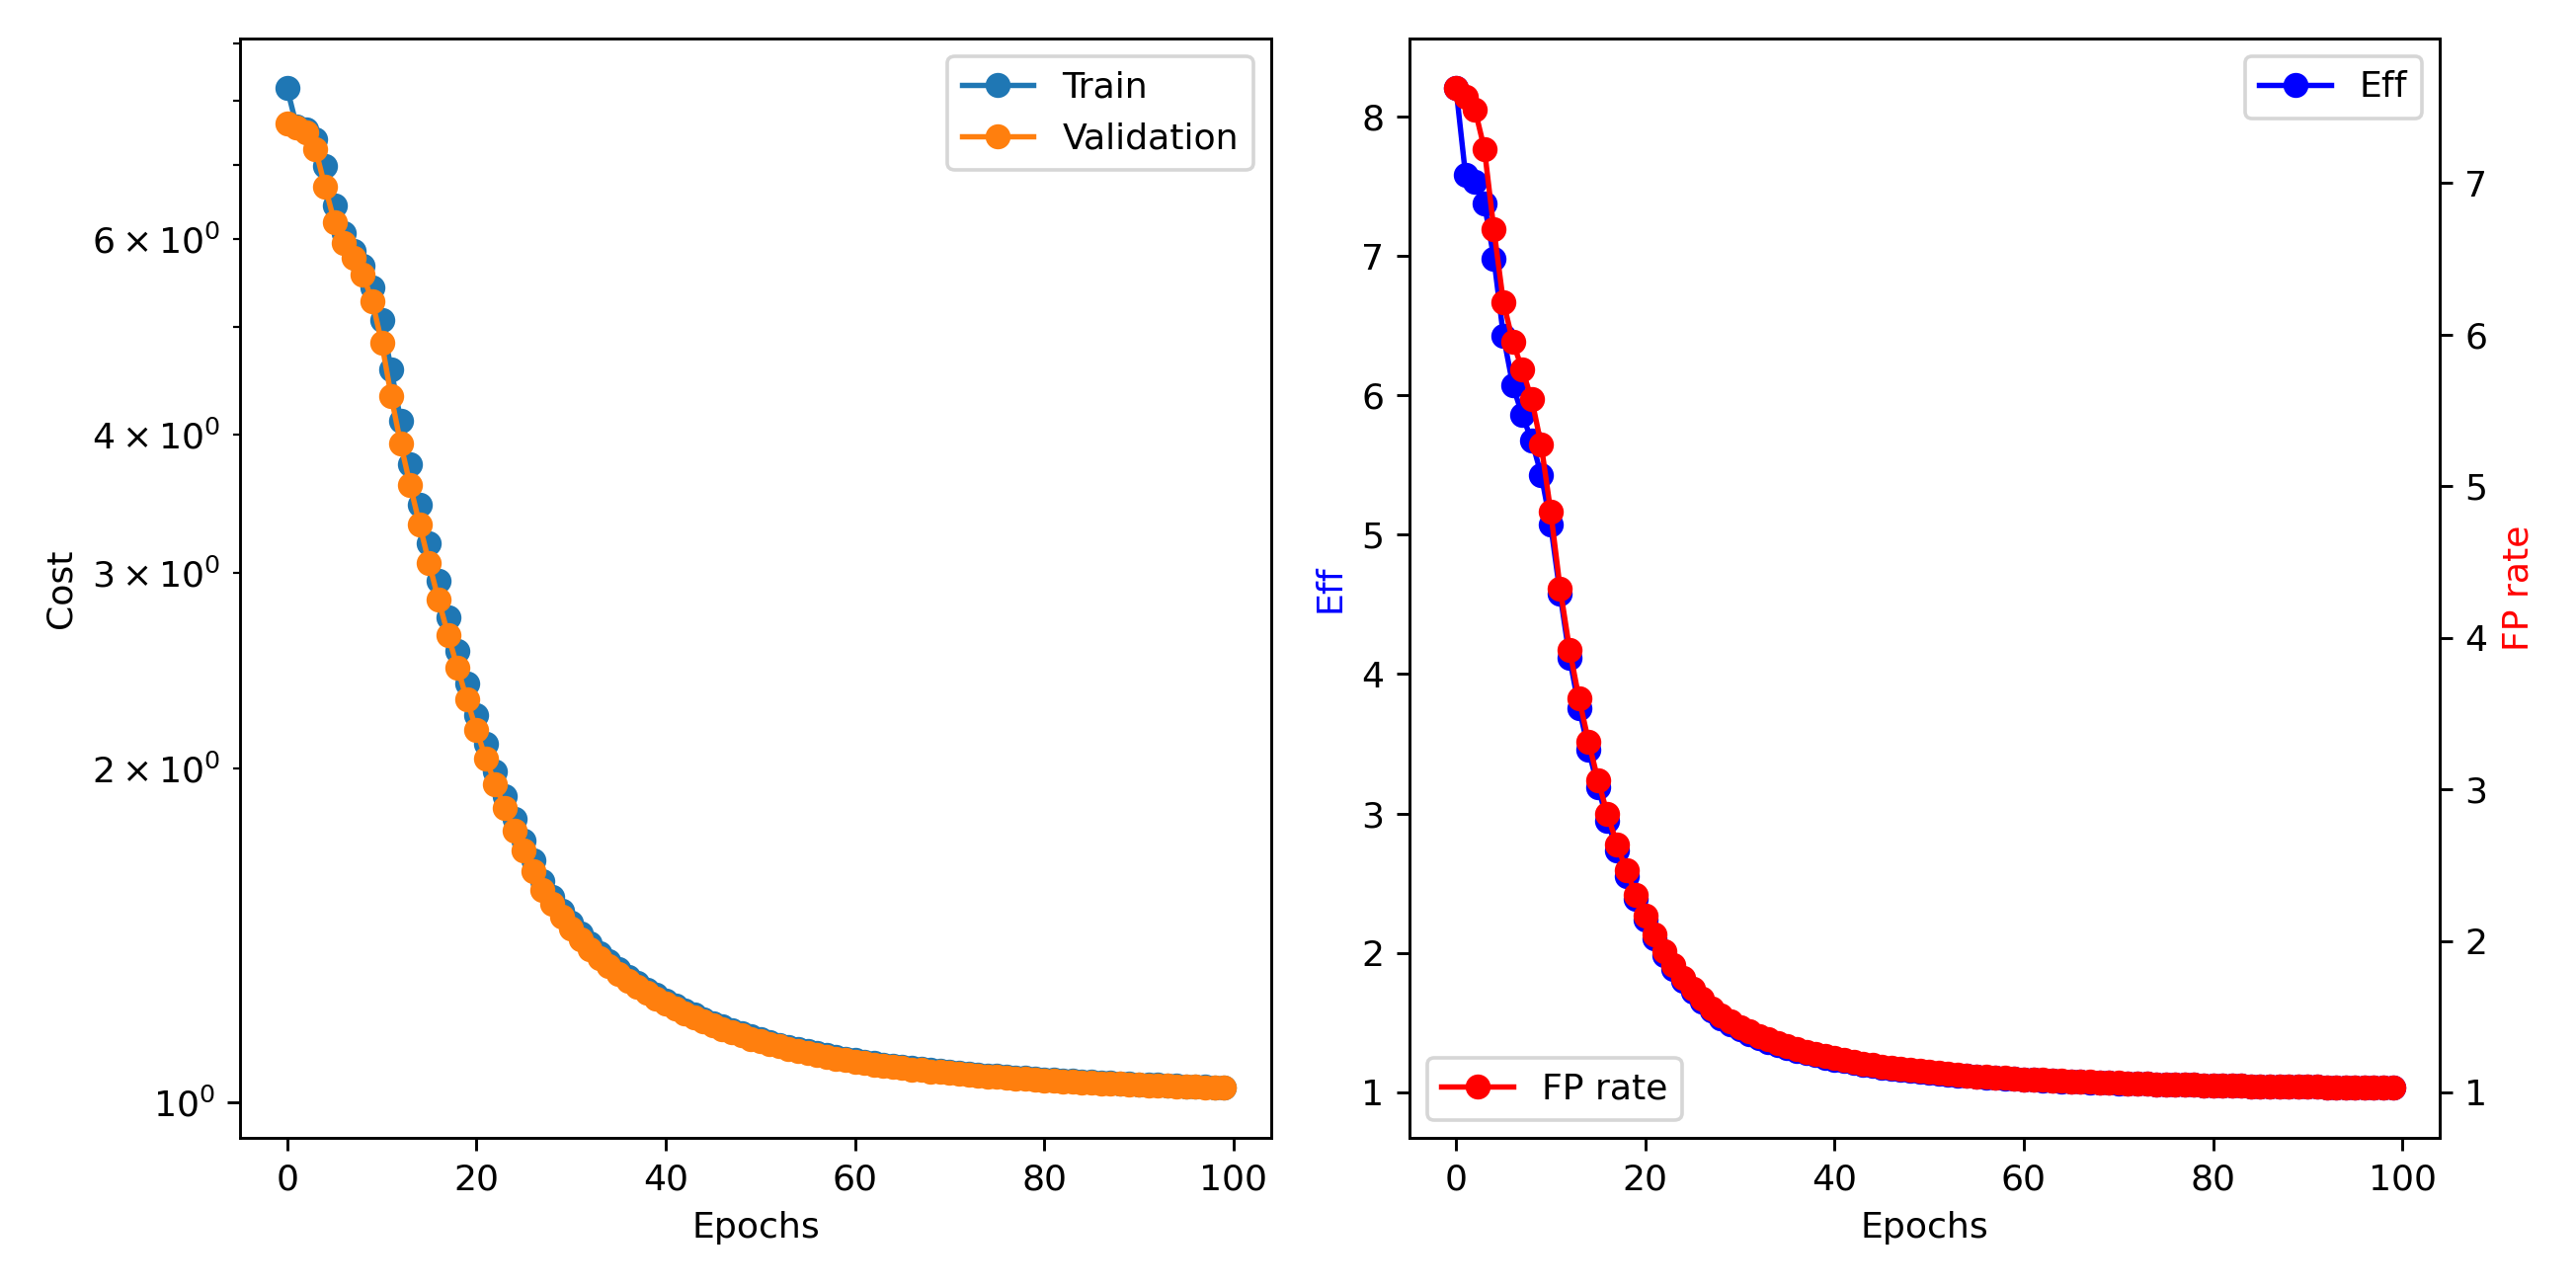

In [24]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [21]:
##quit()
